In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import monad
reload(monad)

<module 'monad' from 'monad.py'>

Approach adapted from https://www.labri.fr/perso/nrougier/from-python-to-numpy/#boids

### Begin with a 2D LJ simulation

This will be a 2-dimensional simulation of Lennard-Jones particles using all dimensionless parameters:
* Time step $t = 1$
* Particle mass $m = 1$
* Temperature $T = 1$
* LJ potential width $\sigma=1$
* LJ potential depth $\epsilon=1$

In [37]:
# Define simulation settings
n = 16
L = 50.  # Simulation box size
sigma = 1.
epsilon = 1.
rcut = 5.
dtlog = 10 # Log to trajectory every dtlog time steps

In [38]:
pos = monad.initialize_positions(n, L)

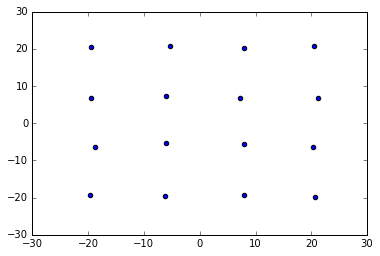

In [39]:
# Visualize uniform initial positions in simulation box
plt.scatter(pos[:,0], pos[:,1])

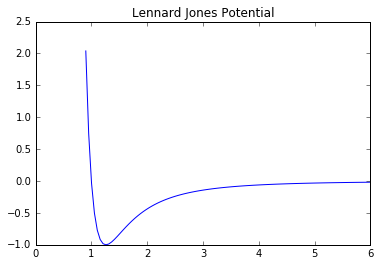

In [41]:
x = np.linspace(.9, 6, 100)
pot = monad.lj_potential(x, 1, 1)
plt.plot(x, pot)
plt.title('Lennard Jones Potential')

In [53]:
# Initialize:
init_pos = monad.initialize_positions(n, L)
init_vel = monad.initialize_velocities(n)

In [42]:
# Run dynamics (short)
traj, vetraj, ketraj = monad.run(init_pos, init_vel, L, nframes=100, dtlog=1, rcut=20)

In [54]:
# Run dynamics (longer)
traj, vetraj, ketraj = monad.run(init_pos, init_vel, L, nframes=5000, dtlog=10, rcut=20)

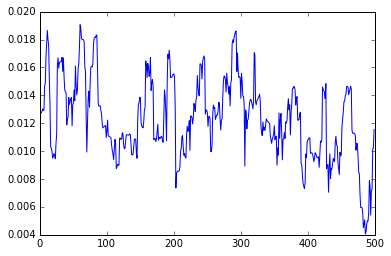

In [55]:
plt.plot(ketraj[:,0])

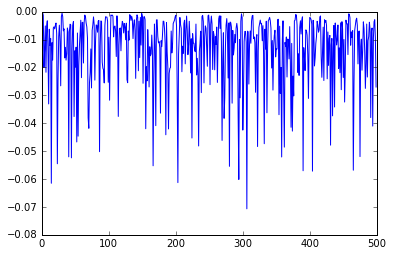

In [56]:
plt.plot(vetraj)

## Visualize the trajectory

IndexError: index 500 is out of bounds for axis 0 with size 500

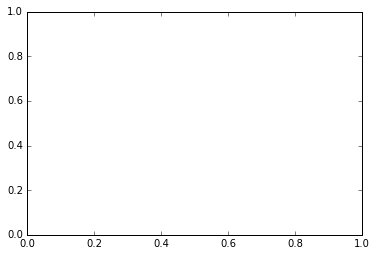

In [58]:
for i in range(0,1000,2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(*traj[i].T)
    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(-L/2, L/2)
    fig.savefig('f/{}.png'.format(i), dpi=100, bbox_inches='tight')
    plt.close(fig)